In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import linear_model
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

In [2]:
df = pd.read_csv('VA_crime_table_2013.csv')
df.columns = df.columns.str.replace('\n', ' ')
df.columns

Index(['City', 'Population', 'Violent crime',
       'Murder and nonnegligent manslaughter', 'Rape (revised definition)1',
       'Rape (legacy definition)2', 'Robbery', 'Aggravated assault',
       'Property crime', 'Burglary', 'Larceny- theft', 'Motor vehicle theft',
       'Arson'],
      dtype='object')

In [3]:
fix = ['Population', 'Violent crime', 'Rape (legacy definition)2', 'Robbery', 'Aggravated assault', 
       'Property crime', 'Burglary', 'Larceny- theft', 'Motor vehicle theft']
#fixing commas in the numeric columns
for key in fix:
    df[key] = pd.to_numeric(df[key].astype(str).str.replace(',',''), errors='coerce')
df.dropna(axis=0, how='all', inplace=True)
df.drop(df.loc[df['Population'].isnull()].index, inplace=True)
#Use to make sure all the values are now numerical
df.dtypes
display(df.isnull().any())

City                                    False
Population                              False
Violent crime                           False
Murder and nonnegligent manslaughter    False
Rape (revised definition)1              False
Rape (legacy definition)2                True
Robbery                                 False
Aggravated assault                      False
Property crime                          False
Burglary                                False
Larceny- theft                          False
Motor vehicle theft                     False
Arson                                   False
dtype: bool

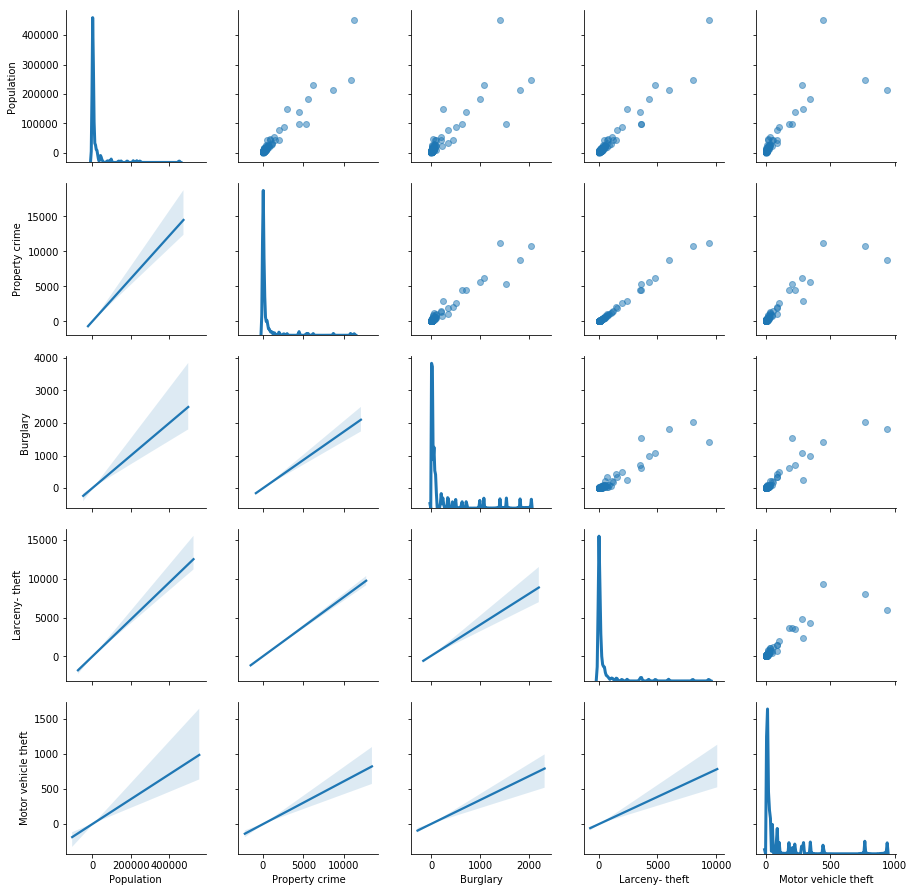

In [4]:
#Set up facetgrid to analyze some features related to property crime
df_explore = df.loc[:, ['City', 'Population', 'Property crime', 'Burglary', 'Larceny- theft', 'Motor vehicle theft']]
data_to_plot = df_explore.loc[:, 'Population':'Motor vehicle theft']
g = sns.PairGrid(data_to_plot, diag_sharey=False)
g.map_upper(plt.scatter, alpha=.5)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.kdeplot, lw=3)
plt.show()
#seeing heavy bias due to outliers

In [5]:
#removing outliers in the data
label = df.loc[
    df['Property crime']>(df['Property crime'].quantile(0.90))]
df = df.drop(label.index)

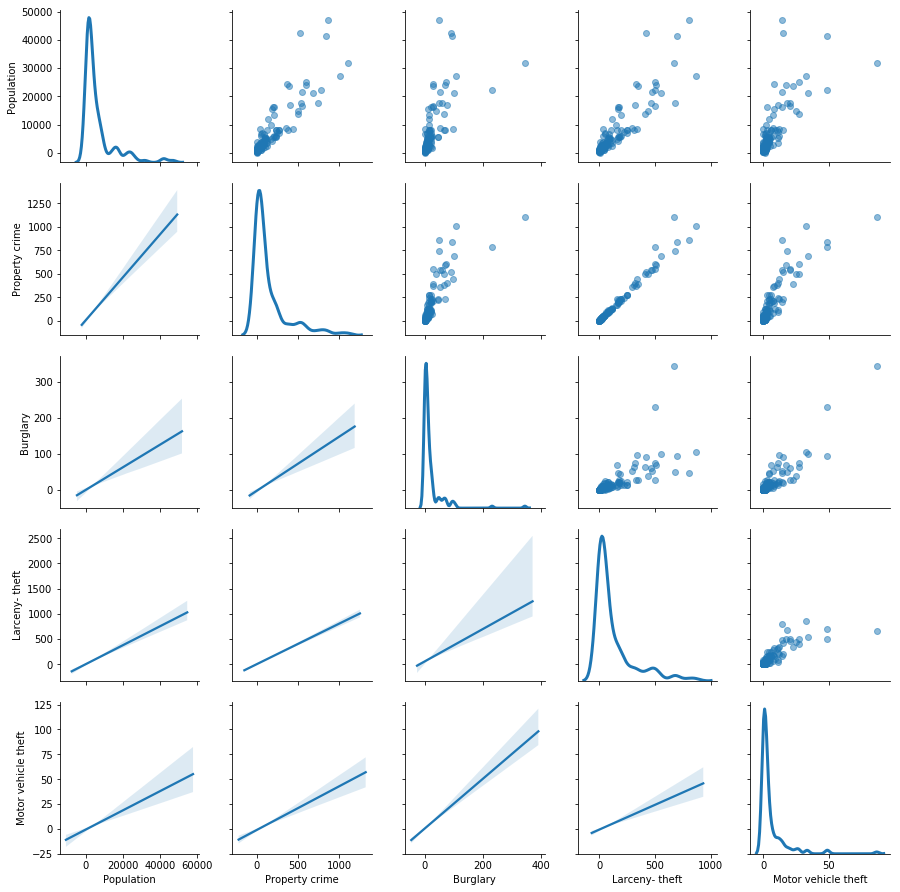

In [6]:
df_explore = df.loc[:, ['City', 'Population', 'Property crime', 'Burglary', 'Larceny- theft', 'Motor vehicle theft']]
data_to_plot = df_explore.loc[:, 'Population':'Motor vehicle theft']
g = sns.PairGrid(data_to_plot, diag_sharey=False)
g.map_upper(plt.scatter, alpha=.5)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.kdeplot, lw=3)
plt.show()

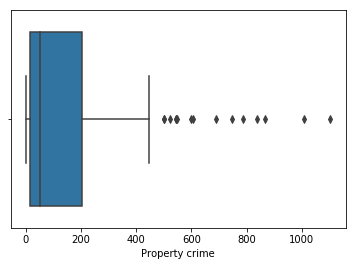

In [7]:
sns.boxplot(df['Property crime'])
#making a copy for a revised model after outlier cleaning
rdf = df.copy()
#Still considered as outliers?

In [8]:
#features for the model
df['Population^2'] = df['Population'].map(lambda x: x**2)
df['Murder'] = np.where(df['Murder and nonnegligent manslaughter']>0, 1, 0)
df['Robbery_feature'] = np.where(df['Robbery']>0, 1, 0)

# Collinearity check

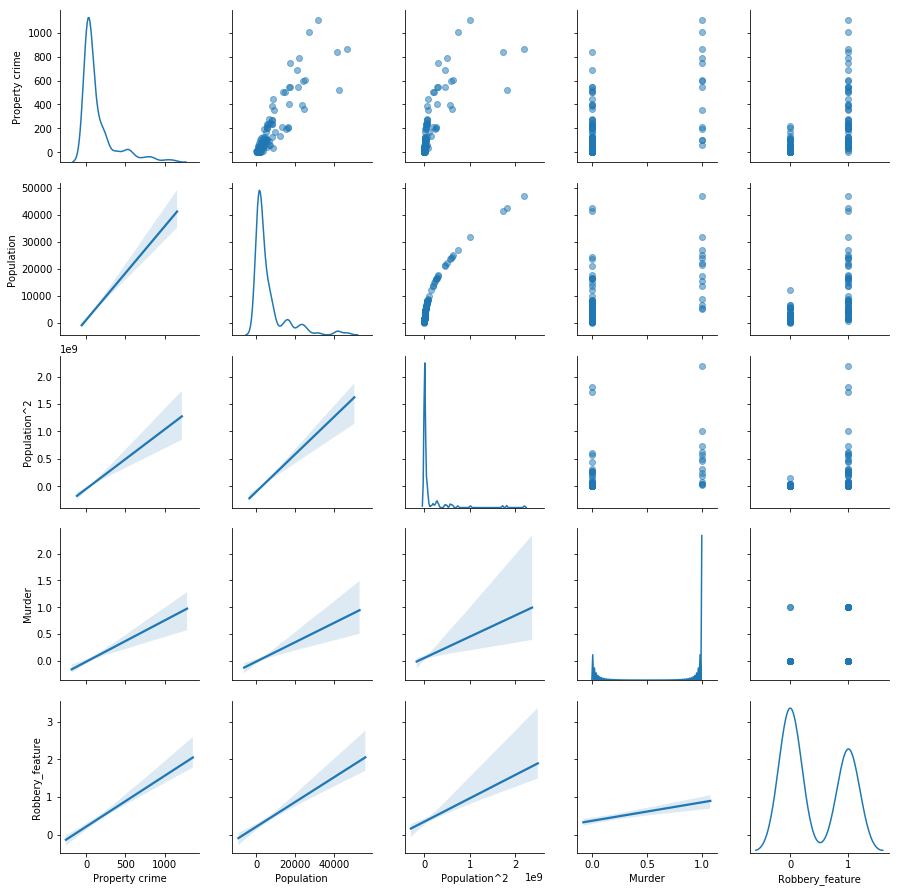

In [9]:
#checking for collinearity b/w features
ndf = df[['Property crime', 'Population', 'Population^2', 'Murder', 'Robbery_feature']]
t = sns.PairGrid(ndf.loc[:,:], diag_sharey=False)
t.map_upper(plt.scatter, alpha=.5)
t.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
t.map_diag(sns.kdeplot)

# Fit Model

In [10]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df['Property crime'].values.reshape(-1, 1)
X = df[['Population', 'Murder', 'Robbery_feature']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[1.88207637e-02 1.04017855e+02 6.50069174e+01]]

Intercept: 
 [-5.23622873]

R-squared:
0.8203513184507791


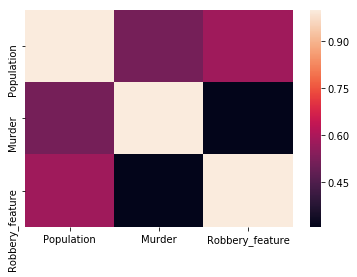

In [11]:
sns.heatmap(X.corr())
#Population and population^2 explaining the same variance, which can result in overfitting for this particular model
#need to run cross_validation at the end to confirm

# checking multivariate normality

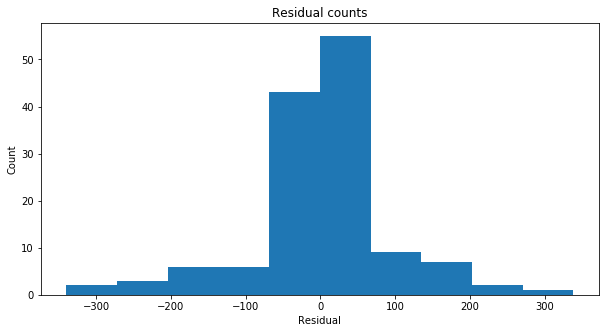

In [12]:
actual = df['Property crime']
predicted = regr.predict(X).ravel()
residual = predicted-actual

plt.figure(figsize=(10,5))
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

# Homoscedasticity check

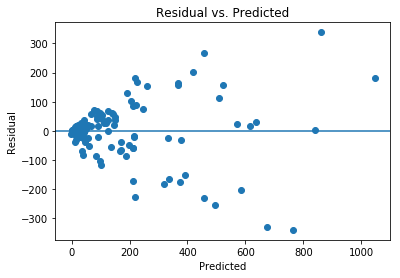

In [13]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [14]:
display(X.corr())
#correlation amongst variables is less than .8 so thats some good sign

,Population,Murder,Robbery_feature
Population,1.000,0.512,0.579
Murder,0.512,1.000,0.304
Robbery_feature,0.579,0.304,1.000


# Validation

In [15]:
df['Property_crime'] = df['Property crime']
linear_formula = 'Property_crime ~ Population+Murder+Robbery_feature'
lm = smf.ols(linear_formula, df).fit()

In [16]:
print("\nParameter coefficients\n",lm.params)
print("\nP-Values\n",lm.pvalues)
print("\nR squared value\n", lm.rsquared)


Parameter coefficients
 Intercept          -5.236
Population          0.019
Murder            104.018
Robbery_feature    65.007
dtype: float64

P-Values
 Intercept         0.640
Population        0.000
Murder            0.001
Robbery_feature   0.002
dtype: float64

R squared value
 0.8203513184507791


In [17]:
lm.conf_int()

,0,1
Intercept,-27.332,16.859
Population,0.016,0.021
Murder,41.563,166.473
Robbery_feature,24.194,105.819


In [18]:
#cross validation
X_train, X_test, Y_train, Y_test = train_test_split(X, df['Property_crime'], test_size=.2, random_state=20)
print('With 20% Holdout: {}'.format(regr.fit(X_train, Y_train).score(X_test, Y_test))) #score shows the accuracy
print('Testing on Sample: {}'.format(regr.fit(X, df['Property_crime']).score(X, df['Property_crime'])))
#signs of overfitting

With 20% Holdout: 0.5946156905751359
Testing on Sample: 0.8203513184507791


In [19]:
#At 10 folds, the model shows signs of overfitting
cross_val_score(regr, X, df['Property_crime'], cv=6)

array([0.5347819 , 0.75545952, 0.85193733, 0.88518829, 0.84117929,
       0.72629842])

# Revised model

In [20]:
#features for the model
rdf['Population^2'] = df['Population'].map(lambda x: x**2)
rdf['Murder'] = np.where(df['Murder and nonnegligent manslaughter']>0, 1, 0)
rdf['Robbery_feature'] = np.where(df['Robbery']>0, 1, 0)
rdf['Motor_theft'] = np.where(rdf['Motor vehicle theft']>0, 1, 0)

In [21]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = rdf['Property crime'].values.reshape(-1, 1)
X = rdf[['Population^2', 'Murder', 'Robbery_feature', 'Motor_theft']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[3.64389506e-07 1.70711525e+02 1.30855740e+02 5.27998839e+01]]

Intercept: 
 [1.43320985]

R-squared:
0.7471048995799991


# Collinearity check

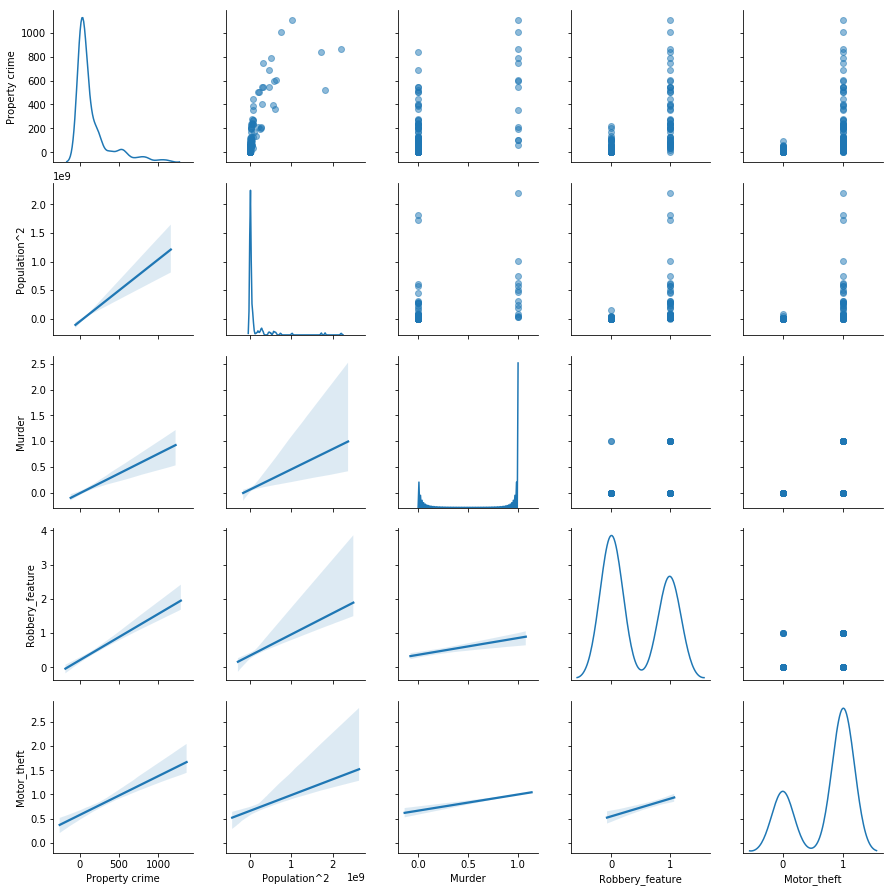

In [22]:
data_to_plot = rdf.loc[:,['Property crime', 'Population^2', 'Murder', 'Robbery_feature', 'Motor_theft']]
x = sns.PairGrid(data_to_plot, diag_sharey=False)
x.map_upper(plt.scatter, alpha=.5)
x.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
x.map_diag(sns.kdeplot)

# Multivariate normality

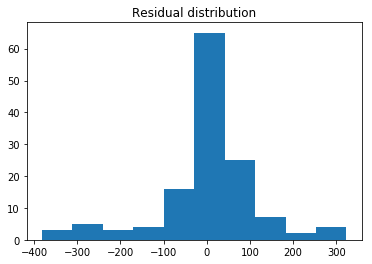

In [23]:
actual = rdf['Property crime']
predicted = regr.predict(X).ravel()
residual = predicted - actual

plt.hist(residual)
plt.title("Residual distribution")
plt.show()

In [24]:
drop = rdf.loc[np.abs(residual)>residual.quantile(.95)]
rdf = rdf.drop(drop.index)

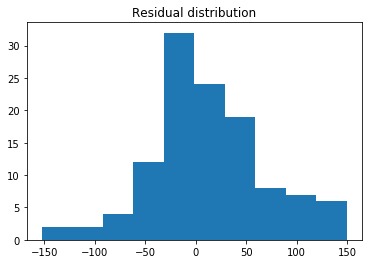

In [25]:
actual = rdf['Property crime']
X = rdf[['Population^2', 'Murder', 'Robbery_feature', 'Motor_theft']]
predicted = regr.predict(X).ravel()
residual = predicted - actual

plt.hist(residual)
plt.title("Residual distribution")
plt.show()

# Homoscedasticity check

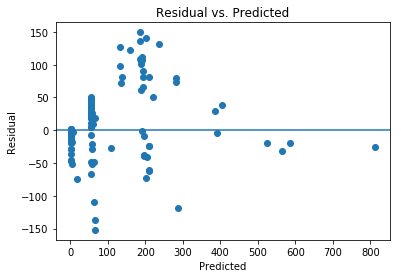

In [27]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [29]:
display(X.corr())
#no high values show that features are independent

,Population^2,Murder,Robbery_feature,Motor_theft
Population^2,1.000,0.320,0.376,0.202
Murder,0.320,1.000,0.208,0.154
Robbery_feature,0.376,0.208,1.000,0.324
Motor_theft,0.202,0.154,0.324,1.000


# Validation

In [30]:
rdf['Property_crime'] = rdf['Property crime']
linear_formula = 'Property_crime ~ Population+Murder+Robbery_feature'
lm = smf.ols(linear_formula, df).fit()

In [31]:
print("\nParameter coefficients\n",lm.params)
print("\nP-Values\n",lm.pvalues)
print("\nR squared value\n", lm.rsquared)


Parameter coefficients
 Intercept          -5.236
Population          0.019
Murder            104.018
Robbery_feature    65.007
dtype: float64

P-Values
 Intercept         0.640
Population        0.000
Murder            0.001
Robbery_feature   0.002
dtype: float64

R squared value
 0.8203513184507791


In [33]:
lm.conf_int()

,0,1
Intercept,-27.332,16.859
Population,0.016,0.021
Murder,41.563,166.473
Robbery_feature,24.194,105.819


In [37]:
#cross validation
X_train, X_test, Y_train, Y_test = train_test_split(X, rdf['Property_crime'], test_size=.2, random_state=19)
print('With 20% Holdout: {}'.format(regr.fit(X_train, Y_train).score(X_test, Y_test))) #score shows the accuracy
print('Testing on Sample: {}'.format(regr.fit(X, rdf['Property_crime']).score(X, rdf['Property_crime'])))

With 20% Holdout: 0.8948815510940022
Testing on Sample: 0.8669768487825036


In [38]:
#showing some signs of overfitting, although slightly better scores than last model
cross_val_score(regr, X, rdf['Property_crime'], cv=8)

array([0.57168325, 0.82686428, 0.75572113, 0.80253114, 0.86143099,
       0.81335288, 0.87253485, 0.74886514])